# Initial Data ETL and EDA

## 2. Data Exploration

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
# Loading
import json
# import pyspark
# from pyspark.sql import SparkSession

# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Basic text processing
import html
import re
import string
import pickle
# import spacy
# from common import vocabulary

# NLTK processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Additional processing
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from collections import Counter
from unicodedata import normalize
# from wordcloud import WordCloud

### 2.1 Load data using PySpark

In [ ]:
spark = SparkSession.builder.appName('Test').getOrCreate()

In [ ]:
mags_meta = spark.read.json('data/magazine_subscriptions_meta.json')
mags = spark.read.json('data/magazine_subscriptions.json')

In [ ]:
books = spark.read.json('data/books.json')
books_meta = spark.read.json('data/books_meta.json')

In [ ]:
mags.printSchema()

In [ ]:
mags_meta.printSchema()

In [ ]:
books_meta.printSchema()

In [ ]:
book_reviews.printSchema()

In [ ]:
books_meta.count()

In [ ]:
books.count()

In [ ]:
mag_categories = mags_meta.groupBy('category')
mag_categories.count().show()

In [ ]:
mags_pd = mags.toPandas()
mags_meta_pd = mags_meta.toPandas()

### 2.2 Load data using pandas

In [43]:
# Note - runtime is untenable on the books data in local jupyter notebook

# books_meta = pd.read_json('../data/books_meta.json', lines=True)
# books = pd.read_json('../data/books.json', lines=True)
meta = pd.read_json('../data/magazine_subscriptions_meta.json', lines=True)
reviews = pd.read_json('../data/magazine_subscriptions.json', lines=True)

In [44]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

reviews = reviews.rename(columns=camel_to_snake)
meta = meta.rename(columns=camel_to_snake)

In [45]:
# Drop duplicate records of a unique ASIN
meta.drop_duplicates(subset='asin', inplace=True)

# Drop reviews with no reviewText
reviews = reviews[reviews['review_text'].isna() == False]

# Convert vote column to numeric
reviews['vote'] = reviews['vote'].str.replace(',', '').fillna(0).astype(int)

In [46]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(reviews.shape)
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
reviews.info()
print("\n")

Dataframe Shape
(89656, 12)


Column Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89656 entries, 0 to 89688
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   overall           89656 non-null  int64 
 1   vote              89656 non-null  int64 
 2   verified          89656 non-null  bool  
 3   review_time       89656 non-null  object
 4   reviewer_id       89656 non-null  object
 5   asin              89656 non-null  object
 6   reviewer_name     89654 non-null  object
 7   review_text       89656 non-null  object
 8   summary           89640 non-null  object
 9   unix_review_time  89656 non-null  int64 
 10  style             51378 non-null  object
 11  image             133 non-null    object
dtypes: bool(1), int64(3), object(8)
memory usage: 8.3+ MB




In [47]:
reviews['review_text'][1]

'Thank god this is not a Ziff Davis publication.  MaxPC will actually tell you if a product is bad. They will print just what they think about something; no sugar coating. I would compare their style to Car and Driver. Technical, but they know how to have a good time.'

In [48]:
reviews.iloc[0]

overall                                                             5
vote                                                                9
verified                                                        False
review_time                                                11 8, 2001
reviewer_id                                             AH2IFH762VY5U
asin                                                       B00005N7P0
reviewer_name                                            ted sedlmayr
review_text         for computer enthusiast, MaxPC is a welcome si...
summary                        AVID READER SINCE "boot"  WAS THE NAME
unix_review_time                                           1005177600
style                                                             NaN
image                                                             NaN
Name: 0, dtype: object

In [49]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(meta.shape)
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
meta.info()
print("\n")

Dataframe Shape
(2320, 19)


Column Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2320 entries, 0 to 3384
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   category            2320 non-null   object        
 1   tech1               2320 non-null   object        
 2   description         2320 non-null   object        
 3   fit                 2320 non-null   object        
 4   title               2320 non-null   object        
 5   also_buy            2320 non-null   object        
 6   tech2               2320 non-null   object        
 7   brand               2320 non-null   object        
 8   feature             2320 non-null   object        
 9   rank                2320 non-null   object        
 10  also_view           2320 non-null   object        
 11  details             2320 non-null   object        
 12  main_cat            2320 non-null   object        
 13  

In [50]:
meta.iloc[0].category

['Magazine Subscriptions',
 'Professional & Educational Journals',
 'Professional & Trade',
 'Humanities & Social Sciences',
 'Economics & Economic Theory']

### 2.3 Meta data transformation

In [51]:
categories = ['category', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
meta[categories] = pd.DataFrame(meta['category'].to_list())
meta.replace('amp;', '', regex=True, inplace=True)

In [52]:
meta['category'].value_counts(dropna=False)

NaN                       1201
Magazine Subscriptions    1119
Name: category, dtype: int64

In [53]:
subcat = 'subcat1'
meta[subcat].value_counts(dropna=False)

NaN                                    1201
Professional & Educational Journals     370
Sports, Recreation & Outdoors           137
Travel, City & Regional                 117
Fashion & Style                          61
Home & Garden                            44
Entertainment & Pop Culture              41
Arts, Music & Photography                40
Children & Teen                          39
Business & Investing                     32
Cooking, Food & Wine                     31
Lifestyle & Cultures                     26
Literary, Sci-Fi & Mystery               25
Crafts & Hobbies                         23
Automotive & Motorcycles                 21
Science, History & Nature                17
Religion & Spirituality                  16
Health, Fitness & Wellness               14
News & Political Commentary              14
Technology                               14
Women's Interest                         10
Pets & Animals                            8
Parenting & Families            

In [54]:
meta['brand'].value_counts(dropna=False)

Hearst Magazines              255
Conde Nast                    184
                              147
Meredith                       48
Bonnier Corporation            43
                             ... 
Supertrax                       1
National Assn of Rocketry       1
Columbia Journalism Review      1
Woodenboat Publications         1
TI Golf Holdings                1
Name: brand, Length: 943, dtype: int64

In [55]:
def count_if(group):
    '''Count the values of a boolean column that are True'''
    return np.sum(group==True)

# Use groupby and agg to summarize relevant statistics from review data by each ASIN
asin_stats = reviews.groupby('asin').agg({'asin': 'count',
                                          'overall': 'mean',
                                          'verified': count_if                                         
                                         })

# Rename columns and reset index
asin_stats.rename(columns={'asin':'reviews',
                           'overall':'avg_rating',
                           'verified': 'reviews_verified'
                          },
                  inplace=True
                 )
asin_stats.reset_index(inplace=True)

# Merge ASIN statistics df with original metadata, drop irrelevant columns
asins = pd.merge(meta,
                asin_stats,
                on='asin',
                how='left'
               )

asins = asins[['asin', 'subcat1', 'brand', 'reviews', 'reviews_verified', 'avg_rating']]
asins['pct_verified'] = asins['reviews_verified'] / asins['reviews']
asins.head()

,asin,subcat1,brand,reviews,reviews_verified,avg_rating,pct_verified
0,B00005N7NQ,Professional & Educational Journals,Reason Magazine,117.0,56.0,3.803419,0.478632
1,B00005N7OC,"Arts, Music & Photography",String Letter Publishers,31.0,6.0,2.645161,0.193548
2,B00005N7OD,Fashion & Style,Conde Nast Publications,193.0,64.0,3.725389,0.331606
3,B00005N7O9,"Sports, Recreation & Outdoors",AirAge Publishing,23.0,16.0,4.434783,0.695652
4,B00005N7O6,Professional & Educational Journals,EPG Media & Specialty Information,64.0,50.0,4.531250,0.781250


In [56]:
print("\033[1m" + "Column Information" + "\033[0m")
print(asins.describe())

Column Information
           reviews  reviews_verified   avg_rating  pct_verified
count  2319.000000       2319.000000  2319.000000   2319.000000
mean     36.733937         24.641225     4.116051      0.684337
std     118.689026         84.413756     0.881121      0.325099
min       1.000000          0.000000     1.000000      0.000000
25%       2.000000          1.000000     3.750000      0.500000
50%       6.000000          4.000000     4.266667      0.753906
75%      20.000000         14.000000     4.800000      1.000000
max    1718.000000       1315.000000     5.000000      1.000000


### 2.4 Meta data visualization

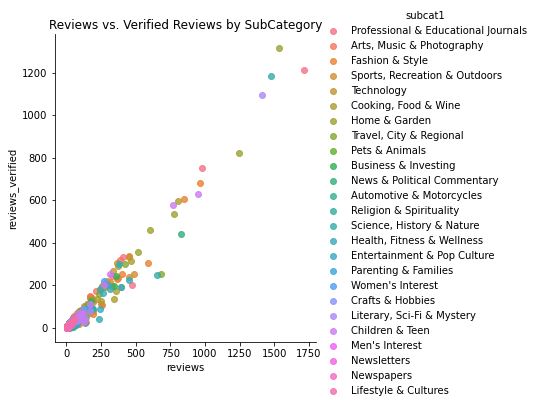

In [57]:
sns.lmplot(x='reviews', y='reviews_verified', data=asins, hue='subcat1', fit_reg=False)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

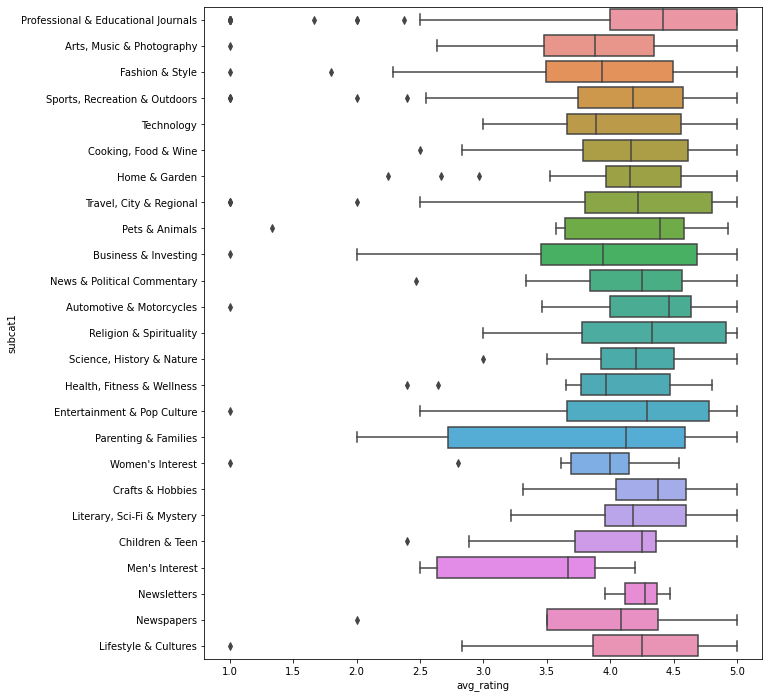

In [58]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='avg_rating', y='subcat1', orient='h', data=asins)
# sns.swarmplot(x='avgRating', y='subcat1', orient='h', data=asins, color='.1')
plt.show()

### 2.5 Filter and random sampling

In [59]:
# Filter ASINs to reviews >= 10
asin_samples = asins[asins['reviews'] >= 5]

# Filter ASINs to subcat1 >= 10
# Need to consider whether I want to do this or not
# cat_counts = asin_samples['subcat1'].value_counts(dropna=False)
# asin_samples = asin_samples.loc[asin_samples['subcat1'].isin(cat_counts[cat_counts >= 30].index), :]

asin_samples.shape

(1365, 7)

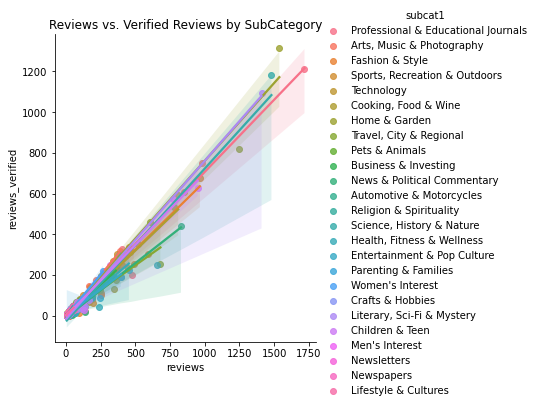

In [60]:
sns.lmplot(x='reviews', y='reviews_verified', data=asin_samples, hue='subcat1', fit_reg=True)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

In [61]:
# Filter reviews based on asin_samples
review_samples = pd.merge(reviews,
                          asin_samples,
                          on='asin',
                          how='inner'
                         )

In [62]:
# Random sample 5 reviews from each ASIN
# This is likely over-sampling - DON'T USE 
# review_samples = review_samples.groupby('asin').sample(n=5, random_state=1)

In [63]:
print(reviews.shape)
print(review_samples.shape)

(89656, 12)
(83228, 18)


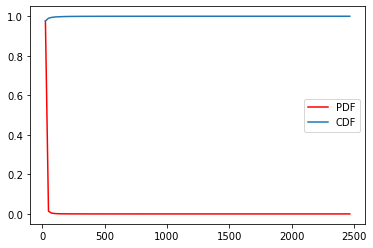

In [64]:
data = review_samples['vote']
  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=100)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.show()

In [65]:
# Remove outliers greater than 3 std-dev above mean votes for usefulness
# This makes visualization more interpretable, but likely not a good idea for modeling
# Because we want the outliers to be considered the "most useful"

# outlier_threshold = review_samples.describe()['vote']['mean'] +\
#                     (review_samples.describe()['vote']['std'] * 3)

# review_samples = review_samples[review_samples['vote'] <= outlier_threshold]

In [66]:
# Remove reviews with X votes

min_votes = 10
review_samples = review_samples[review_samples['vote'] >= min_votes]

In [67]:
print(reviews.shape)
print(review_samples.shape)

(89656, 12)
(5583, 18)


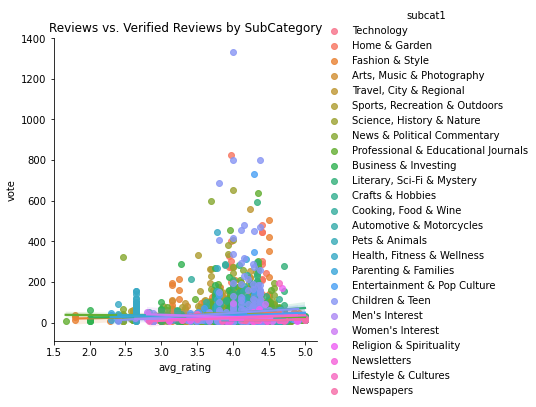

In [68]:
sns.lmplot(x='avg_rating', y='vote', data=review_samples, hue='subcat1', fit_reg=True)\
   .set(title='Reviews vs. Verified Reviews by SubCategory')

plt.show()

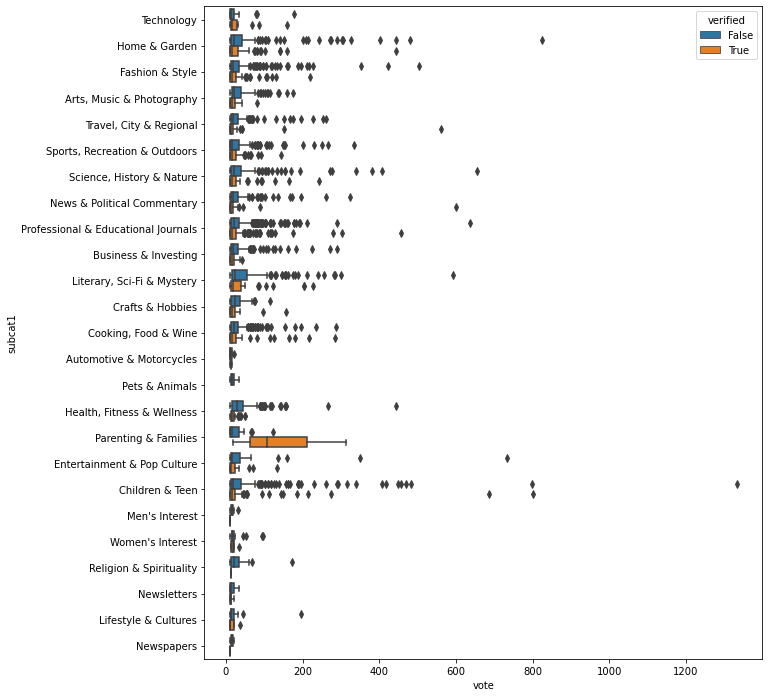

In [69]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='vote', y='subcat1', hue='verified', orient='h', data=review_samples)
# sns.swarmplot(x='vote', y='subcat1', hue='verified', orient='h', data=review_samples)
plt.show()

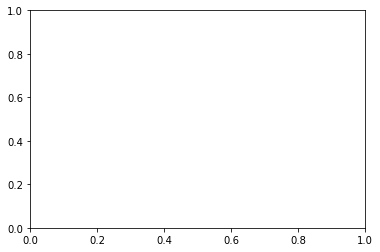

In [70]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[review_samples['vote'] < 10])
plt.show()

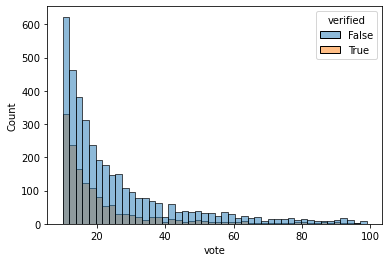

In [71]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[(review_samples['vote'] >= 10) & (review_samples['vote'] < 100)])
plt.show()

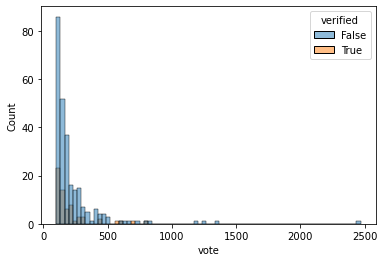

In [72]:
sns.histplot(x='vote',
             hue='verified',
             data=review_samples[review_samples['vote'] >= 100])
plt.show()

In [73]:
# Explore skew and kurtosis functions in pandas and scipy
pd_skew    = review_samples['vote'].skew()
pd_kurt    = review_samples['vote'].kurt()
sci_skew   = skew(review_samples['vote'], bias=False)
sci_kurt   = kurtosis(review_samples['vote'], bias=False)
sci_skew_b = skew(review_samples['vote'], bias=True)
sci_kurt_b = kurtosis(review_samples['vote'], bias=True)

pd.DataFrame({'skew': [pd_skew, sci_skew, sci_skew_b],
              'kurtosis': [pd_kurt, sci_kurt, sci_kurt_b]},
             index=['pandas', 'scipy-unbiased', 'scipy-biased']
            )

,skew,kurtosis
pandas,13.803361,347.782625
scipy-unbiased,13.803361,347.782625
scipy-biased,13.799652,347.470163


In [74]:
# Normalize vote variable
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# Take the log10 of votes
review_samples['vote_norm'] = boxcox(review_samples['vote'], lmbda=0)

# Apply power transformation
pt = PowerTransformer()
review_samples['vote_power'] = pt.fit_transform(pd.DataFrame(review_samples['vote']))

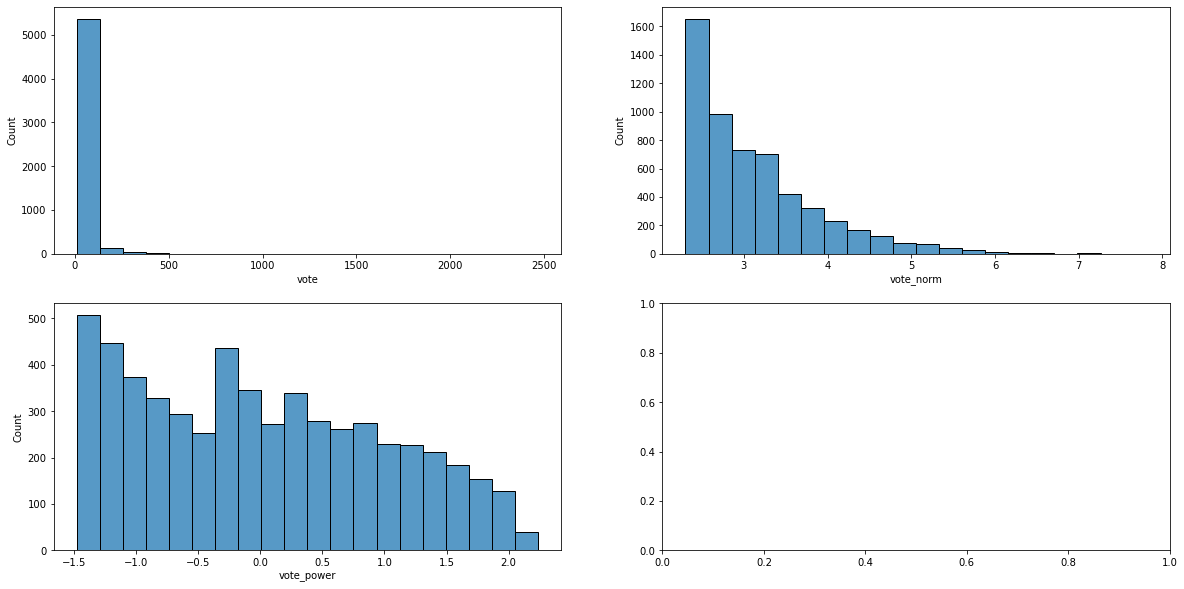

In [75]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.histplot(x='vote',
             data=review_samples,
             bins=20,
             ax=ax[0][0]
            )

sns.histplot(x='vote_norm',
             data=review_samples,
             bins=20,
             ax=ax[0][1]
            )

sns.histplot(x='vote_power',
             data=review_samples,
             bins=20,
             ax=ax[1][0]
            )

plt.show()

In [76]:
# Define the usefulness classification based on vote_power variable

review_samples['useful'] = review_samples['vote_power'].apply(lambda x: 1 if x > 0 else 0)
review_samples['useful'].value_counts()

0    2982
1    2601
Name: useful, dtype: int64

## 3. Text pre-processing

In [77]:
# Use html library to decode special characters
html_reviews = review_samples[review_samples['review_text'].str.contains('&#', na=False)]

if html_reviews.empty:
    # Doesn't appear to be an issue in this data, but will use the else statement to check
    pass
else:
    # Show an example of the unescape function
    sample_review = html_reviews['review_text'].iloc[0]
    print(sample_review)
    print("")
    decoded_review = html.unescape(sample_review)
    print(decoded_review)

In [78]:
# Remove special characters
pattern = r"\&\#[0-9]+\;"

review_samples["review_text"] = review_samples["review_text"].str.replace(pat=pattern, repl="", regex=True)

### 3.1 Lemmatization

In [79]:
# Use lemmatization to reduce words to their root form

# import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource, quiet=True)

In [80]:
%%time
# create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

# apply functions to review text
review_samples["review_processed"] = review_samples["review_text"].apply(lambda row: lemmatize_doc(row))

# Example review
print(review_samples["review_text"].iloc[1])
print("")
print(review_samples["review_processed"].iloc[1])
print("")

Confirming as of April 2010 - The magazines do NOT come packaged with the software CD's as pictured on the product page, nor does the description disclaim that this is some kind no-CD subscription of the magazine.

The reviews on the ridiculous time frames in which you receive your first issue are, unfortunately, true as well. The description claims 6-10 weeks, but it could take several months longer.

Falsely advertised; buy directly through Maximum PC or a more reliable source where you'll actually get all 12 months with all 12 software discs, rather than 6-10 issues with no discs.

This product is NOT the product described. It's as simple as that.

Confirming as of April 2010 - The magazine do NOT come package with the software CD s as picture on the product page nor do the description disclaim that this be some kind no-CD subscription of the magazine The review on the ridiculous time frame in which you receive your first issue be unfortunately true as well The description claim 6-1

### 3.2 General normalization

In [81]:
# Remove accents

remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
review_samples["review_processed"] = review_samples["review_processed"].apply(remove_accent)

# Remove punctuation
pattern = r"[^\w\s]"
review_samples["review_processed"] = review_samples["review_processed"].str.replace(pat=pattern, repl=" ", regex=True)

# Convert to lowercase
review_samples["review_processed"] = review_samples["review_processed"].str.lower()

# Remove stopwords
stop_words = stopwords.words("english")
stop_words = [word.replace("\'", "") for word in stop_words]
# print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") if token not in stop_words])
review_samples["review_processed"] = review_samples["review_processed"].apply(remove_stop_words)

# Remove extra spaces
pattern = r"[\s]+"
review_samples["review_processed"] = review_samples["review_processed"].str.replace(pat=pattern, repl=" ", regex=True)

# Example review
print(review_samples["review_text"].iloc[1])
print("")
print(review_samples["review_processed"].iloc[1])

Confirming as of April 2010 - The magazines do NOT come packaged with the software CD's as pictured on the product page, nor does the description disclaim that this is some kind no-CD subscription of the magazine.

The reviews on the ridiculous time frames in which you receive your first issue are, unfortunately, true as well. The description claims 6-10 weeks, but it could take several months longer.

Falsely advertised; buy directly through Maximum PC or a more reliable source where you'll actually get all 12 months with all 12 software discs, rather than 6-10 issues with no discs.

This product is NOT the product described. It's as simple as that.

confirming april 2010 magazine come package software cd picture product page description disclaim kind cd subscription magazine review ridiculous time frame receive first issue unfortunately true well description claim 6 10 week could take several month longer falsely advertise buy directly maximum pc reliable source actually get 12 month

### 3.3 Tokenization and vocabulary

In [82]:
# Create corpora
corpora = review_samples['review_text'].values
tokenized = [corpus.split(" ") for corpus in corpora]

In [83]:
# Setup phrase modeling
bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=50, threshold=50)

In [84]:
# Unigrams
uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:200])

['symbolize', 'BRITAIN', 'tactlessly,', 'Need', 'amazing', 'Cadillac', 'non-glossy', 'Horny', "'magazine'", 'veggies,', 'Goofs', 'sub-par,', 'arduous', 'Kobo,', '"Definitely', 'use', 'nightmarish', "idea's", 'Welcome,', 'Report.\n\nBack', 'publications)', 'Celebrity', 'Create', 'coder.', 'perspectives,', 'misinformation,', '$$.', 'Leon', 'years...these', 'less?', 'mantras', 'bothered', 'them.\n\nHighly', 'Eventually', 'teeny-weeny', 'imitators', 'Oaxaco,', 'presents', 'discourse', 'authorative,', 'wire.', 'Nirvana,', 'struggles', 'going.\n\nGarden', 'hell,', 'prep.', "Kim's", 'T&L;', 'apologized', "'Ladybug'", 'walleye,', 'cars,', 'mysteriously', "other's", '(Includes', 'utilzed', 'ratings!', "Fest\nBuick\n\nThat's", 'read?"', 'cheerleading-piece', '6)', 'analyses', 'shabby', 'CARE', 'delish,', 'friend),', 'pocketbook.\n\nI', 'pre', 'enterer', 'traced', 'classification', 'get.\n\nWho', 'Train.', '39', 'Hue(not', 'resolve', 'reviewer,', 'clarification:', "Guideposts.\nI'm", 'perspective

In [85]:
# Bigrams
bigram_min = bi_gram.min_count
bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set(bi_gram_tokens)

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only))

['', 'This_is', 'at_the', 'magazine_and', 'some_of', 'with_a', 'there_is', 'I_was', 'this_magazine.', 'lot_of', 'subscribed_to', 'a_subscription', 'have_been', 'has_a', 'the_first', 'that_the', '_It', 'on_a', 'magazine_that', 'in_the', 'a_good', 'from_the', 'This_magazine', 'of_my', 'is_the', 'as_well', 'magazine_is', 'want_to', 'the_best', 'have_a', 'a_lot', '_I', "I_don't", 'as_a', 'I_will', 'you_are', 'I_had', 'you_can', 'this_is', 'to_see', 'for_the', 'but_I', 'the_articles', 'subscription_to', 'is_that', 'on_the', 'magazine._', 'to_a', 'to_find', 'If_you', 'a_few', 'and_it', 'there_are', 'the_same', 'a_great', 'The_magazine', 'to_read', 'they_are', 'I_am', '_They', 'I_love', 'the_magazine', 'to_be', 'I_can', 'I_have', 'my_subscription', 'if_you', 'the_most', 'of_a', 'that_are', 'of_the', 'and_a', '_This', 'It_is', 'about_the', 'to_this', 'it_was', 'all_the', 'the_Kindle', 'was_a', 'be_a', 'that_I', 'I_would', 'There_are', 'magazine_for', 'I_think', 'by_the', 'to_make', 'with_the',

In [86]:
# Trigrams 
trigram_min = tri_gram.min_count

tri_condition = lambda x: x[1] >= trigram_min

tri_gram_tokens = dict(filter(tri_condition, tri_gram.vocab.items()))
tri_gram_tokens = set(tri_gram_tokens)

tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)
print(list(tri_grams_only)[:50])

['know_how', 'amazing', 'Maybe', 'plain', 'up_in', 'you_need', 'would_recommend', 'for_about', 'I_really', 'line', 'paying', 'for_you.', 'sort', 'this_and', 'says', 'started', 'and_in', 'here.', 'need_to', 'are_the', 'immediately', 'guy', 'Journal', 'covering', 'photos', 'loved', 'with_no', 'terms', "It's_a", 'with_my', 'healthy', 'love_to', 'at_my', 'of_articles', '(I', 'reviews.', 'face', 'who_has', 'it,', 'plenty_of', 'enjoy_this', 'and_you', 'Just', 'I_know', 'reads', 'again,', 'time.', 'will_be', 'might_be', 'format']


### X.X Output sampled and processed data to CSV

In [87]:
review_samples.to_csv('../data/review_samples.csv')